In [ ]:
!pip install roboflow

In [ ]:
from roboflow import Roboflow
# Initialize Roboflow
rf = Roboflow(api_key="2HwWY6P6WKdW09kFR4fW")

# Download the dataset
project = rf.workspace("mohamed-traore-2ekkp").project("face-detection-mik1i")
version = project.version(22)
dataset = version.download("voc")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Face-Detection-22 in voc:: 100%|██████████| 6571/6571 [00:00<00:00, 9184.98it/s]


In [ ]:
import os
import xml.etree.ElementTree as ET
import cv2

def parse_voc_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    bboxes = []
    for obj in root.findall('object'):
        bbox = obj.find('bndbox')
        x = int(bbox.find('xmin').text)
        y = int(bbox.find('ymin').text)
        w = int(bbox.find('xmax').text) - x
        h = int(bbox.find('ymax').text) - y
        bboxes.append((x, y, w, h))
    return bboxes

def load_images_and_bboxes(image_dir, annotations_dir):
    images = []
    bboxes = []
    for xml_file in os.listdir(annotations_dir):
        if xml_file.endswith('.xml'):
            image_file = xml_file.replace('.xml', '.jpg')
            image_path = os.path.join(image_dir, image_file)
            annotation_path = os.path.join(annotations_dir, xml_file)

            image = cv2.imread(image_path)
            if image is not None:
                images.append(image)
                bboxes.append(parse_voc_xml(annotation_path))
    return images, bboxes

image_dir = '/content/Face-Detection-22/train'
annotations_dir = '/content/Face-Detection-22/train'
images, bboxes = load_images_and_bboxes(image_dir, annotations_dir)


In [ ]:
def apply_mosaic(image, bboxes, kernel_size=(7, 7), interpolation=cv2.INTER_LINEAR):
    for bbox in bboxes:
        x, y, w, h = bbox

        # Ensure the bounding box dimensions do not exceed the image dimensions
        if x < 0 or y < 0 or x + w > image.shape[1] or y + h > image.shape[0]:
            continue

        roi = image[y:y+h, x:x+w]
        mosaic = cv2.resize(roi, (kernel_size[1], kernel_size[0]), interpolation=interpolation)  # Adjust kernel_size and interpolation
        mosaic = cv2.resize(mosaic, (w, h), interpolation=cv2.INTER_NEAREST)  # Use INTER_NEAREST for better mosaic effect

        # Ensure mosaic dimensions match ROI dimensions
        if mosaic.shape != roi.shape:
            mosaic = mosaic[:roi.shape[0], :roi.shape[1]]

        image[y:y+h, x:x+w] = mosaic
    return image

# Apply mosaic to each image with adjusted parameters
mosaic_images = []
for image, bbox_list in zip(images, bboxes):
    mosaic_image = apply_mosaic(image.copy(), bbox_list, kernel_size=(7, 7), interpolation=cv2.INTER_LINEAR)
    mosaic_images.append(mosaic_image)

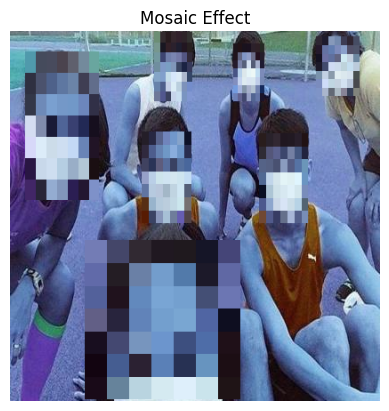

In [ ]:
image = (mosaic_images[5] * 255).astype('uint8')
plt.imshow(image)
plt.title('Mosaic Effect')
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# Convert lists to numpy arrays
images = np.array(images).astype('float32') / 255.0
mosaic_images = np.array(mosaic_images).astype('float32') / 255.0

# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(images, mosaic_images, test_size=0.2, random_state=42)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

def build_autoencoder(input_shape):
    input_img = Input(shape=input_shape)

    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    return autoencoder

# Define the input shape based on your images
input_shape = x_train.shape[1:]  # (height, width, channels)
autoencoder = build_autoencoder(input_shape)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 416, 416, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 416, 416, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 208, 208, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 208, 208, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 104, 104, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 104, 104, 128)     73856 

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Start with an initial batch size
initial_batch_size = 16

try:
    history = autoencoder.fit(
        x_train, y_train,
        epochs=50,
        batch_size=initial_batch_size,
        shuffle=True,
        validation_data=(x_val, y_val),
        callbacks=[early_stopping]
    )
except tf.errors.ResourceExhaustedError:
    print(f"Batch size of {initial_batch_size} is too large, reducing batch size.")
    initial_batch_size = initial_batch_size // 2
    history = autoencoder.fit(
        x_train, y_train,
        epochs=50,
        batch_size=initial_batch_size,
        shuffle=True,
        validation_data=(x_val, y_val),
        callbacks=[early_stopping]
    )


In [ ]:
import matplotlib.pyplot as plt
import cv2

# Load the image file
image_path = "/content/Face-Detection-22/train/-1x-1_jpg.rf.a5b0f4b2c18eeadf7af2614fe6c2ef70.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

input_image = np.expand_dims(image, axis=0)  # Add batch dimension

# Predict using the autoencoder
prediction = autoencoder.predict(input_image)
predicted_image = np.squeeze(prediction, axis=0)  # Remove batch dimension
predicted_image = (predicted_image * 255).astype('uint8')  # Convert back to uint8

1/1 [==============================] - 0s 23ms/step


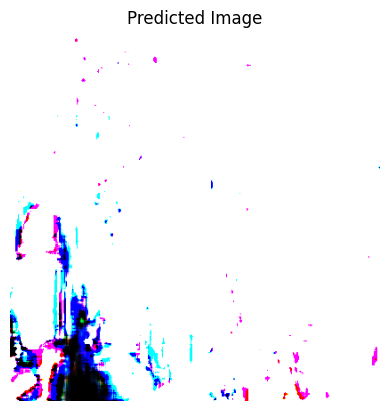

In [ ]:
# Visualize the predicted image
plt.imshow(predicted_image)
plt.title('Predicted Image')
plt.axis('off')
plt.show()

In [ ]:
# Save the trained model
model_save_path = '/content/drive/MyDrive/AISecApp/autoencoder_mid.keras'
autoencoder.save(model_save_path)